In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys
from tqdm import tqdm
from datetime import datetime

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm

from autoencoder import Autoencoder
from solver import train_vali_all_epochs, dev_train_vali_all_epochs, test

In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [3]:
run_id = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
save_path = os.getenv("HOME") + '/sparsify_models/AE/MNIST/' +run_id +'/'
print(save_path)

/home/david/sparsify_models/AE/MNIST/2024-12-06_00-39-40/


In [4]:
from solver import size_per_epoch, develope_AE, train

model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.99)
device = torch.device('cuda')

n_epochs = 50
d_explained_variance_ratios = []
d_latent_matrices = []

size_ls = [4, 4, 4, 4, 4, 4, 
           10, 10, 10, 10, 10, 10, 
           16, 16, 16, 16, 16, 16, 
           24, 24, 24, 24, 24, 24, 
           32, 32, 32, 32, 32, 32,
           32, 32, 32, 32, 32, 32, 
           32, 32, 32, 32, 32, 32, 
           32, 32, 32, 32, 32, 32, 
           32, 32]
manner = 'cell_division'

def dev_train_vali_all_epochs(model,size_ls,manner,train_loader,vali_loader,optimizer,n_epochs,device,save_path=None):
	if save_path is None:
		save_path = './'
	else:
		if not os.path.exists(save_path):
			os.makedirs(save_path)
			print('Directory created:', save_path)
	train_losses = []
	all_train_losses = []
	vali_losses = []
	size_each_epoch = size_per_epoch(size_ls,n_epochs,type='step')
	np.save(save_path + 'size_each_epoch.npy',size_each_epoch)
	hyperparam = model.get_hyperparams()

	for epoch in range(n_epochs):
		print(size_each_epoch[epoch])
		model.train()
		# Create new autoencoder with corresponding bottleneck size
		new_n_hidden_ls = np.append(hyperparam['n_hidden_ls'][:-1] , size_each_epoch[epoch])
		if epoch == 0:
			model = Autoencoder(hyperparam['n_input'],new_n_hidden_ls,hyperparam['n_layers'])

		else:
			model = develope_AE(new_n_hidden_ls,hyperparam,save_path=save_path,epoch=epoch,manner=manner)
			optimizer = torch.optim.SGD(model.parameters(),lr=1e-1,momentum=0.9)
			
		train_loss,train_loss_per_batch = train(model,train_loader,optimizer,epoch,device)
		vali_loss,_,_ = test(model,vali_loader,device)
		train_losses.append(train_loss)
		all_train_losses.append(train_loss_per_batch)
		vali_losses.append(vali_loss)

		# Save the weights of the last epoch.
		torch.save(model.state_dict(), save_path + 'model_weights_epoch{}.pth'.format(epoch))
		print('Weights saved.')

		model.eval()
		latent_list = []

		# Loop through validation data
		with torch.no_grad():  # Gradients not calculated
			for batch_idx, (data, target) in enumerate(test_loader):
				# Convert to a PyTorch variable
				data = Variable(data).to('cpu')

				# Flatten the input data into a 2D tensor [batch_size, num_features]
				batch_size = data.size(0)
				input = data.view(batch_size, -1).to('cpu')

				encoded = model(input)[0]

				latent_list.append(encoded.cpu().numpy())

		latent_matrix = np.concatenate(latent_list)
		print(latent_matrix.shape)
		print(latent_matrix)

		# Perform PCA on number of latent variables available in the bottleneck
		# Max 10 components
		# if size_each_epoch[epoch] < 10:
		# 	pca = PCA(n_components=size_each_epoch[epoch])
		# else:
		# 	pca = PCA(n_components=10)
		pca = PCA(n_components=size_each_epoch[epoch])
		pca.fit(latent_matrix)

		d_explained_variance_ratios.append(pca.explained_variance_ratio_)
		d_latent_matrices.append(pca.components_)

	np.save(save_path + 'all_train_losses.npy',all_train_losses)
	print('All train losses saved.')
	return d_latent_matrices

dev_train_vali_all_epochs(
	model,
	size_ls,
	manner,
	train_loader,
	test_loader,
	optimizer,
	n_epochs,
	device='cpu',
	save_path=save_path+'Dev/{}/'.format(manner)
	)

Directory created: /home/david/sparsify_models/AE/MNIST/2024-12-06_00-39-40/Dev/cell_division/
4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001326: 100%|██████████| 469/469 [00:03<00:00, 140.32it/s]


====> Epoch: 0 Average loss: 0.1223


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1245
Weights saved.
(10000, 4)
[[ 0.07798185  0.00353456 -0.03850616 -0.00873678]
 [ 0.11216521 -0.02814832 -0.00273174  0.03131589]
 [ 0.02158309 -0.04118661 -0.00792201 -0.02887258]
 ...
 [ 0.08456343 -0.08638082  0.04863204 -0.02999308]
 [ 0.07215204  0.05180154  0.00972704  0.00085431]
 [ 0.05865354 -0.21874246  0.04731704 -0.09491422]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0617



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0511
Weights saved.
(10000, 4)
[[ 0.2559471   0.93846077  0.23768759  0.09789948]
 [ 0.7996348  -0.83586955  0.33490378 -0.49538705]
 [ 0.33066744 -0.16687655 -0.44371665 -0.5312133 ]
 ...
 [ 0.667437    0.4684558   0.39707035  0.11495644]
 [ 0.6231764   0.5915014   0.35080713 -0.47320595]
 [ 0.44548568 -0.5032522   1.4316537   0.49707475]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0495



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0486
Weights saved.
(10000, 4)
[[ 0.04928233  0.8727438   0.30561247  0.16408408]
 [ 0.76243573 -0.9711522   0.33909947 -0.5356071 ]
 [ 0.41230386 -0.17294398 -0.46711755 -0.51550555]
 ...
 [ 0.96465987  0.912888    0.19113544  0.30861297]
 [ 0.8329732   0.6576774   0.25608853 -0.4981778 ]
 [ 0.95931536 -0.29268384  1.2103312   0.63674146]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[-0.16793692  0.82465243  0.331229    0.15077132]
 [ 0.78909785 -0.97667325  0.31158704 -0.5168917 ]
 [ 0.46316287 -0.16531503 -0.48302066 -0.5052872 ]
 ...
 [ 0.72692484  0.9219608   0.20448568  0.33739215]
 [ 0.8744543   0.6617421   0.22329283 -0.46873805]
 [ 1.3448825  -0.2139906   1.1215894   0.72454655]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0484



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0481
Weights saved.
(10000, 4)
[[-0.28290668  0.8136528   0.337017    0.12870866]
 [ 0.79807496 -0.97881705  0.30391204 -0.5081587 ]
 [ 0.4777746  -0.1638645  -0.48669767 -0.49588943]
 ...
 [ 0.46314228  0.9048203   0.2538954   0.275768  ]
 [ 0.8663693   0.6627917   0.22493492 -0.45726746]
 [ 1.4982679  -0.19462481  1.0971521   0.79204875]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0483



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[-0.32638133  0.8183099   0.3459823   0.10856787]
 [ 0.79310393 -0.98719686  0.30761153 -0.5215853 ]
 [ 0.4723689  -0.161241   -0.48766255 -0.49524677]
 ...
 [ 0.29039472  0.8957138   0.31060582  0.190988  ]
 [ 0.8355559   0.64970803  0.23087317 -0.4712155 ]
 [ 1.5276366  -0.18747051  1.0858114   0.8074875 ]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0485



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0478
Weights saved.
(10000, 10)
[[-0.18412538  0.4922858   0.19359306 ...  0.04830813  0.01237971
   0.05549604]
 [ 0.49734816 -0.59135973  0.19367567 ... -0.33426028 -0.00174665
   0.00691393]
 [ 0.29166347 -0.10228424 -0.31882495 ... -0.3203904   0.02224657
   0.01966024]
 ...
 [ 0.13988678  0.5634802   0.19492838 ...  0.05459294 -0.02514548
   0.0050989 ]
 [ 0.50938916  0.4095184   0.1431894  ... -0.29714373  0.02212636
   0.04224411]
 [ 0.9578213  -0.09314787  0.7086375  ...  0.4827593   0.00942659
  -0.04203616]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0463



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0430
Weights saved.
(10000, 10)
[[-0.16340324  0.5315637   0.17379375 ...  0.03070689 -0.26006517
   0.5134341 ]
 [ 0.5334948  -0.6123925   0.1540487  ... -0.3312241  -0.25493082
  -0.11841203]
 [ 0.30827737 -0.08641643 -0.31208625 ... -0.33101314 -0.04567677
   0.20444804]
 ...
 [ 0.18328443  0.5126113   0.08485584 ...  0.06871288 -0.7824706
  -0.22006738]
 [ 0.5381678   0.40517017  0.13795032 ... -0.30979908 -0.17156965
   0.04930463]
 [ 1.0013804  -0.13647327  0.6964179  ...  0.48573297 -0.11277053
  -0.5225715 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0425


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0418
Weights saved.
(10000, 10)
[[-0.17104477  0.5367823   0.18509625 ...  0.03392976 -0.22336501
   0.49529192]
 [ 0.523546   -0.6263512   0.16202028 ... -0.32689157 -0.15276814
  -0.3508437 ]
 [ 0.30448672 -0.08616522 -0.31634772 ... -0.3333644  -0.03359234
   0.22723672]
 ...
 [ 0.18632287  0.504618    0.04448372 ...  0.08348967 -0.9349507
  -0.25094733]
 [ 0.53317285  0.3848558   0.12114511 ... -0.30161968 -0.16360188
  -0.14609072]
 [ 0.9922801  -0.1519605   0.69361806 ...  0.48548108 -0.01077506
  -0.7055982 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-0.16961057  0.5277015   0.18682086 ...  0.03174177 -0.17450273
   0.41054487]
 [ 0.5237507  -0.63685495  0.16076985 ... -0.32529032 -0.08320448
  -0.46064687]
 [ 0.3054089  -0.08821817 -0.3173092  ... -0.32967192 -0.0155209
   0.20590903]
 ...
 [ 0.18943536  0.50005853  0.03592031 ...  0.0790937  -0.973564
  -0.24796851]
 [ 0.52998734  0.37157485  0.1175122  ... -0.2999848  -0.12976512
  -0.22744988]
 [ 0.9917697  -0.15448463  0.6846098  ...  0.48937988  0.05732268
  -0.76537067]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0421


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-0.17319956  0.52167296  0.18745422 ...  0.03381822 -0.13881582
   0.36279145]
 [ 0.5148338  -0.64482635  0.16107562 ... -0.31711006 -0.0436312
  -0.5146514 ]
 [ 0.30018616 -0.09086302 -0.31715676 ... -0.32925868 -0.00146618
   0.18946531]
 ...
 [ 0.18944156  0.5026683   0.02814537 ...  0.08126908 -0.98444176
  -0.2561466 ]
 [ 0.52369785  0.36070547  0.11518872 ... -0.29707122 -0.10966074
  -0.27325514]
 [ 0.98203045 -0.16259584  0.6770214  ...  0.48870254  0.09564036
  -0.8048877 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-0.1754529   0.518849    0.18593784 ...  0.03028127 -0.12000141
   0.33552018]
 [ 0.50911784 -0.6442114   0.15536766 ... -0.3179994  -0.02314624
  -0.54577374]
 [ 0.30362764 -0.0931131  -0.3147642  ... -0.32946151  0.00601807
   0.18047407]
 ...
 [ 0.19128141  0.49704888  0.02893379 ...  0.0772984  -0.9832642
  -0.25839606]
 [ 0.5195999   0.3561692   0.11289041 ... -0.2945844  -0.09386683
  -0.29298922]
 [ 0.98887104 -0.16397977  0.66985226 ...  0.48092017  0.11739245
  -0.82331014]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0420


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0416
Weights saved.
(10000, 16)
[[-0.17136477  0.5177579   0.18634637 ...  0.05501835  0.02192089
  -0.06506457]
 [ 0.51167166 -0.64227587  0.15752442 ...  0.05022206 -0.01699554
  -0.02682242]
 [ 0.30207974 -0.08897494 -0.3116906  ...  0.04358365 -0.00338302
  -0.02673156]
 ...
 [ 0.18390925  0.5017423   0.02955733 ...  0.02672824 -0.00869648
  -0.04688474]
 [ 0.5198347   0.35434884  0.11273964 ...  0.06587282 -0.01074697
  -0.02672937]
 [ 0.9834792  -0.1649433   0.6751597  ...  0.05232704 -0.01326062
  -0.0275924 ]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0415


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0401
Weights saved.
(10000, 16)
[[-1.78938225e-01  5.21463215e-01  1.80141717e-01 ...  1.71051800e-01
   4.60104048e-02 -8.26547146e-02]
 [ 4.91206020e-01 -6.59360588e-01  1.25942737e-01 ...  2.83320129e-01
  -1.56221017e-02  1.38644651e-02]
 [ 2.96227336e-01 -1.04573734e-01 -3.28644633e-01 ...  1.80726409e-01
  -1.21676419e-02  1.96480379e-02]
 ...
 [ 1.84054941e-01  5.17629981e-01  4.31300700e-02 ...  6.06153607e-02
  -4.72960621e-02 -7.80523568e-02]
 [ 5.03922939e-01  3.34334284e-01  8.83088410e-02 ...  2.57240444e-01
  -5.09850606e-02  3.53810042e-02]
 [ 9.68001842e-01 -1.76033840e-01  6.44942105e-01 ...  3.04588318e-01
  -4.63313088e-02  2.04890966e-05]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0388



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0369
Weights saved.
(10000, 16)
[[-0.19404712  0.5225335   0.15287839 ...  0.44342744  0.24549016
  -0.1367535 ]
 [ 0.4796921  -0.6607082   0.09467664 ...  0.45769376  0.10027319
   0.00848571]
 [ 0.29380333 -0.10541168 -0.33213878 ...  0.24818367 -0.02573809
   0.04237723]
 ...
 [ 0.18206733  0.549775    0.02666426 ...  0.27047262 -0.30841622
  -0.06039475]
 [ 0.49987996  0.3318633   0.07272796 ...  0.35456088 -0.16252507
   0.09959079]
 [ 0.96065015 -0.1650732   0.60394    ...  0.58663845 -0.15002757
  -0.03138167]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0355



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0332
Weights saved.
(10000, 16)
[[-0.19769691  0.49577323  0.14409578 ...  0.48349872  0.5291839
  -0.22250414]
 [ 0.47094244 -0.6679103   0.09727231 ...  0.43708852  0.24782684
   0.10813663]
 [ 0.29977423 -0.09303614 -0.32919648 ...  0.27504826 -0.12254505
   0.08898225]
 ...
 [ 0.17984045  0.57816356  0.03111245 ...  0.33406487 -0.56554216
   0.11448245]
 [ 0.48599467  0.33587185  0.0746225  ...  0.42030528 -0.17398486
   0.24175951]
 [ 0.9948973  -0.15555568  0.5933411  ...  0.5524751  -0.34615442
  -0.04855514]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0327



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0318
Weights saved.
(10000, 16)
[[-0.2118657   0.48809972  0.1450635  ...  0.51585215  0.61276853
  -0.23239073]
 [ 0.46306154 -0.66959506  0.09996213 ...  0.45478612  0.28131148
   0.20203988]
 [ 0.3037064  -0.08894581 -0.32929122 ...  0.27684182 -0.18597701
   0.06010504]
 ...
 [ 0.16536048  0.5768265   0.0305445  ...  0.38397974 -0.554136
   0.07297555]
 [ 0.47792977  0.3297953   0.07184422 ...  0.4512604  -0.0609731
   0.22998978]
 [ 1.013296   -0.14925389  0.58844393 ...  0.50728863 -0.41638076
  -0.04596671]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0320



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 16)
[[-2.1890710e-01  4.8291269e-01  1.4344396e-01 ...  5.4114908e-01
   6.4028174e-01 -2.5226146e-01]
 [ 4.5791990e-01 -6.6956156e-01  9.8676726e-02 ...  4.7061974e-01
   2.8157097e-01  1.8870538e-01]
 [ 3.0148989e-01 -8.4432065e-02 -3.2602406e-01 ...  2.7943125e-01
  -2.1957760e-01  4.2037338e-02]
 ...
 [ 1.6169786e-01  5.7493025e-01  2.8646514e-02 ...  4.0006453e-01
  -5.4079419e-01  5.1705763e-02]
 [ 4.7518998e-01  3.2213873e-01  6.5856144e-02 ...  4.6492177e-01
  -6.7332387e-04  1.7667153e-01]
 [ 1.0127949e+00 -1.4618009e-01  5.8455610e-01 ...  4.7860932e-01
  -4.2870545e-01 -3.0413866e-03]]
24
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0319



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 24)
[[-0.22468692  0.4796559   0.1376257  ...  0.12803268 -0.06504225
  -0.07224763]
 [ 0.44793907 -0.6747719   0.09130961 ...  0.09494711 -0.08587331
  -0.04923517]
 [ 0.30258718 -0.08634736 -0.33612767 ...  0.08820514 -0.1000173
  -0.06816588]
 ...
 [ 0.15433817  0.56690586  0.01390834 ...  0.08967052 -0.08943252
  -0.08666179]
 [ 0.46436337  0.31639752  0.06048912 ...  0.10821564 -0.07795149
  -0.053167  ]
 [ 1.0187232  -0.1458582   0.56535846 ...  0.07228626 -0.06219582
  -0.05270044]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 24)
[[-0.22441566  0.4771439   0.13755558 ...  0.13797371 -0.05222917
  -0.07924403]
 [ 0.44372123 -0.675582    0.09217824 ...  0.11011899 -0.08120213
  -0.03949789]
 [ 0.3074892  -0.08343105 -0.33664203 ...  0.05369101 -0.10842855
  -0.05298193]
 ...
 [ 0.15373155  0.5671876   0.01380271 ...  0.08197334 -0.08149478
  -0.08715352]
 [ 0.45677635  0.31224352  0.06178255 ...  0.14010625 -0.06500924
  -0.04962782]
 [ 1.0228248  -0.14131008  0.5594971  ...  0.0447816  -0.05103882
  -0.0431228 ]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 20 Average loss: 0.0315



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0306
Weights saved.
(10000, 24)
[[-0.22351673  0.476474    0.1416495  ...  0.16689678 -0.03389953
  -0.09642027]
 [ 0.4444468  -0.66212255  0.09753717 ...  0.18617314 -0.06658865
  -0.0162271 ]
 [ 0.31197658 -0.08577192 -0.34257618 ... -0.06846563 -0.12930073
  -0.00774009]
 ...
 [ 0.1567367   0.56589574  0.01680127 ...  0.08531472 -0.06442451
  -0.09979341]
 [ 0.4524752   0.3264441   0.07355092 ...  0.3341071  -0.02742107
  -0.07236014]
 [ 1.0276607  -0.14266196  0.552727   ... -0.05036319 -0.04356399
  -0.0121273 ]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 21 Average loss: 0.0305



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0294
Weights saved.
(10000, 24)
[[-2.17394859e-01  4.75202203e-01  1.46793261e-01 ...  1.73481375e-01
   1.49143413e-02 -1.19354546e-01]
 [ 4.37875360e-01 -6.29233956e-01  1.01686418e-01 ...  2.29244143e-01
  -7.29565918e-02  1.76051557e-01]
 [ 3.19852918e-01 -8.31642523e-02 -3.41037154e-01 ... -2.09949166e-01
  -1.30360469e-01  4.65461239e-02]
 ...
 [ 1.65373415e-01  5.63932419e-01  2.22937614e-02 ...  8.60252455e-02
  -3.12503651e-02 -1.31371796e-01]
 [ 4.49352682e-01  3.50160599e-01  7.77927786e-02 ...  5.15341461e-01
  -3.49561945e-02  9.80281830e-03]
 [ 1.03349888e+00 -1.43086001e-01  5.51018775e-01 ... -1.69930458e-01
   4.16472554e-04  2.74634585e-02]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 22 Average loss: 0.0291


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0279
Weights saved.
(10000, 24)
[[-0.20204972  0.4801971   0.16437782 ...  0.15584221  0.11401066
  -0.09859979]
 [ 0.44304243 -0.601003    0.11834788 ...  0.19056952 -0.05087694
   0.39676562]
 [ 0.33395436 -0.07541338 -0.34285778 ... -0.29228163 -0.16139898
   0.02556216]
 ...
 [ 0.17624651  0.56575334  0.02729325 ...  0.05374729  0.00836615
  -0.1865828 ]
 [ 0.45244533  0.3617451   0.08198969 ...  0.53123844 -0.03216101
   0.07042301]
 [ 1.0373815  -0.13902612  0.54671395 ... -0.2335431   0.03927164
   0.04543888]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 23 Average loss: 0.0277



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0267
Weights saved.
(10000, 24)
[[-0.19307432  0.48586452  0.17559177 ...  0.15852654  0.18387145
  -0.06722621]
 [ 0.43435156 -0.590376    0.13215601 ...  0.26239824 -0.02501089
   0.5023922 ]
 [ 0.34496158 -0.07107104 -0.34979576 ... -0.3554543  -0.16869667
  -0.00945142]
 ...
 [ 0.18606235  0.56578875  0.02142443 ... -0.00681215  0.06480816
  -0.23264374]
 [ 0.45802665  0.36044103  0.08330166 ...  0.53618574 -0.01113616
   0.05079904]
 [ 1.0391741  -0.13515973  0.53913003 ... -0.27604553  0.09675071
   0.0510589 ]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 24 Average loss: 0.0267



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0258
Weights saved.
(10000, 32)
[[-0.1748237   0.49050862  0.16614859 ... -0.06478307  0.08771607
   0.01471487]
 [ 0.43231773 -0.5913492   0.13407363 ... -0.00779195  0.10956779
  -0.03116843]
 [ 0.37026805 -0.0682309  -0.3653252  ... -0.09036002  0.07571596
  -0.0291276 ]
 ...
 [ 0.21759427  0.56014675  0.0032161  ... -0.0653996   0.06712556
  -0.04200584]
 [ 0.48754647  0.35844645  0.07347496 ... -0.05355554  0.09929759
  -0.03466212]
 [ 1.0543424  -0.14134237  0.52917504 ... -0.0463208   0.03411354
  -0.03375041]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 25 Average loss: 0.0258



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0248
Weights saved.
(10000, 32)
[[-0.1652813   0.4959029   0.1606684  ... -0.07965505  0.0856958
   0.01250891]
 [ 0.40932694 -0.5853313   0.15079555 ...  0.04084186  0.1162944
  -0.04397209]
 [ 0.38251993 -0.06243926 -0.37358713 ... -0.11082741  0.06878941
  -0.02999482]
 ...
 [ 0.22757861  0.5569194  -0.00567152 ... -0.08203901  0.06053845
  -0.0440609 ]
 [ 0.50358444  0.356647    0.06980622 ... -0.06125073  0.09549087
  -0.04099978]
 [ 1.0503564  -0.14354998  0.536867   ... -0.03607833  0.02660269
  -0.03948443]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 26 Average loss: 0.0250


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0241
Weights saved.
(10000, 32)
[[-0.15324804  0.5029791   0.15450406 ... -0.09649306  0.08455434
   0.01521311]
 [ 0.39649957 -0.5834      0.16100985 ...  0.06418021  0.11627832
  -0.04353465]
 [ 0.39546314 -0.05636224 -0.3795675  ... -0.12419942  0.06395942
  -0.03109564]
 ...
 [ 0.23274037  0.55734116 -0.01197069 ... -0.08524839  0.06258182
  -0.04521621]
 [ 0.5224508   0.3631027   0.06021869 ... -0.0675343   0.09875307
  -0.03872771]
 [ 1.053991   -0.1408723   0.5375357  ... -0.03340561  0.02535953
  -0.03171399]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 27 Average loss: 0.0244



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0237
Weights saved.
(10000, 32)
[[-0.1459919   0.5063131   0.14994842 ... -0.10931093  0.07992742
   0.01156687]
 [ 0.395882   -0.583197    0.1600985  ...  0.06832081  0.10089839
  -0.06330774]
 [ 0.40060398 -0.05459435 -0.38111    ... -0.1301856   0.05448359
  -0.03793912]
 ...
 [ 0.23333947  0.5591618  -0.01436555 ... -0.07207751  0.0775606
  -0.03588672]
 [ 0.5339741   0.37000102  0.05358039 ... -0.05123874  0.12249576
  -0.02687993]
 [ 1.0535856  -0.13467923  0.53708637 ... -0.02096932  0.03677539
  -0.01601047]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 28 Average loss: 0.0239



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0232
Weights saved.
(10000, 32)
[[-0.14358723  0.5068158   0.14741462 ... -0.1213451   0.0755326
   0.00413241]
 [ 0.39576733 -0.5859406   0.16001385 ...  0.06822194  0.06136052
  -0.1050809 ]
 [ 0.40097934 -0.05542186 -0.38066846 ... -0.13330702  0.04251085
  -0.05183855]
 ...
 [ 0.2321065   0.561813   -0.01889069 ... -0.0417365   0.11185522
  -0.01028958]
 [ 0.53760684  0.37419805  0.04955269 ... -0.00321043  0.16738045
  -0.00614089]
 [ 1.0462592  -0.13229017  0.5359084  ... -0.01606837  0.04658776
   0.00177045]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 29 Average loss: 0.0235



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0227
Weights saved.
(10000, 32)
[[-1.44442648e-01  5.08412838e-01  1.45928517e-01 ... -1.19680971e-01
   8.62750113e-02 -2.54741311e-03]
 [ 3.96425307e-01 -5.90344310e-01  1.61669657e-01 ...  1.12046994e-01
   3.31129059e-02 -1.61170453e-01]
 [ 3.98678809e-01 -5.72889373e-02 -3.78335685e-01 ... -1.24064624e-01
   3.92550901e-02 -6.81708157e-02]
 ...
 [ 2.28980958e-01  5.64363837e-01 -2.23154277e-02 ... -3.04120779e-03
   1.62790686e-01  1.98955685e-02]
 [ 5.33426046e-01  3.71645927e-01  4.77196276e-02 ...  6.85548261e-02
   2.15419188e-01 -3.05742025e-04]
 [ 1.04189527e+00 -1.31780580e-01  5.36364138e-01 ... -4.86267656e-02
   2.76404824e-02  6.91094622e-03]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 30 Average loss: 0.0229



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0220
Weights saved.
(10000, 32)
[[-0.14484432  0.51035494  0.14512408 ... -0.11213887  0.10153297
  -0.01150828]
 [ 0.39444622 -0.5974095   0.16651648 ...  0.21253055  0.00494996
  -0.23984797]
 [ 0.39731038 -0.0585409  -0.3754844  ... -0.10912729  0.03905643
  -0.08841671]
 ...
 [ 0.22643857  0.5676856  -0.0291404  ...  0.01468533  0.21727361
   0.06775065]
 [ 0.53046745  0.36653477  0.04791535 ...  0.13293935  0.2530775
  -0.0032456 ]
 [ 1.0378189  -0.13149615  0.53412354 ... -0.09840816 -0.00348829
   0.00606044]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 31 Average loss: 0.0221



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0212
Weights saved.
(10000, 32)
[[-1.45951226e-01  5.11291862e-01  1.47169545e-01 ... -9.66441110e-02
   1.17339134e-01 -2.83546224e-02]
 [ 3.94629091e-01 -6.04058146e-01  1.72369614e-01 ...  2.91618228e-01
  -2.57769488e-02 -3.07084411e-01]
 [ 3.96884173e-01 -5.89448884e-02 -3.72429729e-01 ... -1.05103411e-01
   4.54180017e-02 -1.02022231e-01]
 ...
 [ 2.26949856e-01  5.71098864e-01 -3.43685970e-02 ...  4.09953296e-04
   2.58444548e-01  1.20176494e-01]
 [ 5.34160733e-01  3.63933474e-01  4.63751704e-02 ...  1.35746926e-01
   2.90509433e-01  1.03762858e-02]
 [ 1.03216946e+00 -1.29884213e-01  5.32884777e-01 ... -1.06604718e-01
  -2.90489830e-02 -2.38459930e-03]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 32 Average loss: 0.0214



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0206
Weights saved.
(10000, 32)
[[-0.14555672  0.50891334  0.1479218  ... -0.08107698  0.14541562
  -0.04522402]
 [ 0.39720267 -0.6077619   0.1709181  ...  0.3394339  -0.04305672
  -0.33035553]
 [ 0.39824525 -0.05746781 -0.37143826 ... -0.11558665  0.07204541
  -0.10836685]
 ...
 [ 0.23049337  0.5687826  -0.03905018 ... -0.00506601  0.29949567
   0.14798626]
 [ 0.5397548   0.36406007  0.04412784 ...  0.09291476  0.3488509
   0.00815715]
 [ 1.0237606  -0.12864283  0.5335505  ... -0.10161952 -0.06009848
  -0.00665215]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 33 Average loss: 0.0208



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0200
Weights saved.
(10000, 32)
[[-0.14103894  0.5083162   0.14661439 ... -0.07009175  0.19490442
  -0.06311779]
 [ 0.40313387 -0.6123139   0.16496982 ...  0.37671334 -0.05637499
  -0.350739  ]
 [ 0.4031434  -0.05621411 -0.37075508 ... -0.1337546   0.1232511
  -0.11847898]
 ...
 [ 0.23279674  0.56706274 -0.04169109 ... -0.00859483  0.33455402
   0.16380544]
 [ 0.5504227   0.36595178  0.04199323 ...  0.04262018  0.429314
  -0.02270011]
 [ 1.0136895  -0.12777124  0.5307071  ... -0.08568861 -0.10049094
   0.00739464]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 34 Average loss: 0.0203



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0196
Weights saved.
(10000, 32)
[[-0.12907542  0.5044351   0.14523903 ... -0.05577051  0.257019
  -0.08686382]
 [ 0.40873328 -0.6167996   0.16052857 ...  0.399667   -0.07225336
  -0.37565374]
 [ 0.41003436 -0.05545525 -0.36980549 ... -0.15188307  0.183762
  -0.13667007]
 ...
 [ 0.23314255  0.5658966  -0.04135451 ... -0.01100929  0.36805323
   0.17049606]
 [ 0.55731064  0.36695266  0.0416621  ... -0.00494406  0.5186319
  -0.06166177]
 [ 1.0020754  -0.12710492  0.5285369  ... -0.06758082 -0.15428652
   0.03397512]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 35 Average loss: 0.0200



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0193
Weights saved.
(10000, 32)
[[-0.12254448  0.5030973   0.14314757 ... -0.03853132  0.29242057
  -0.09757999]
 [ 0.40981793 -0.6205575   0.15885894 ...  0.411163   -0.07796095
  -0.4091447 ]
 [ 0.4132265  -0.05366233 -0.36947685 ... -0.15958433  0.21385612
  -0.14006701]
 ...
 [ 0.23217696  0.5652065  -0.04185772 ... -0.00413151  0.38600403
   0.18148279]
 [ 0.5591149   0.36731756  0.0423637  ... -0.03537976  0.56709725
  -0.08930996]
 [ 0.99536157 -0.12737747  0.5273898  ... -0.05349797 -0.1744574
   0.05974539]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 36 Average loss: 0.0197



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0191
Weights saved.
(10000, 32)
[[-0.11727065  0.50162995  0.14111076 ... -0.02507524  0.30357355
  -0.08784333]
 [ 0.41073847 -0.62507737  0.15811376 ...  0.41818383 -0.07691055
  -0.44323498]
 [ 0.41428667 -0.05254785 -0.36939907 ... -0.16331393  0.22069718
  -0.1363199 ]
 ...
 [ 0.23400138  0.5651888  -0.04277191 ... -0.00109153  0.3897506
   0.18793608]
 [ 0.5565543   0.3671669   0.04441567 ... -0.05721406  0.58455324
  -0.10916585]
 [ 0.9932866  -0.12676741  0.525681   ... -0.04807504 -0.16827913
   0.07679546]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 37 Average loss: 0.0196



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0190
Weights saved.
(10000, 32)
[[-0.113653    0.5004467   0.13842475 ... -0.00785983  0.30660433
  -0.07981643]
 [ 0.40987206 -0.6278275   0.15635294 ...  0.42207792 -0.07769838
  -0.46613544]
 [ 0.4130731  -0.05213591 -0.3690973  ... -0.16157252  0.21762799
  -0.13201028]
 ...
 [ 0.2331276   0.56274116 -0.04316396 ...  0.00587356  0.39073533
   0.18866752]
 [ 0.55185914  0.36590508  0.04480512 ... -0.07299936  0.5911605
  -0.12344578]
 [ 0.9906653  -0.12778391  0.5233564  ... -0.04431016 -0.16286406
   0.08473836]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 38 Average loss: 0.0195



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0189
Weights saved.
(10000, 32)
[[-0.11188468  0.49908265  0.13675696 ...  0.00411765  0.30318522
  -0.07033326]
 [ 0.41050556 -0.6267747   0.15609697 ...  0.42505452 -0.08263226
  -0.4691062 ]
 [ 0.4123504  -0.0511493  -0.36874288 ... -0.15964179  0.21211734
  -0.12706509]
 ...
 [ 0.23358354  0.561796   -0.0442066  ...  0.0102669   0.3873992
   0.18935993]
 [ 0.5490704   0.36764264  0.04470482 ... -0.08771169  0.5941355
  -0.12648533]
 [ 0.98940384 -0.12877257  0.5214913  ... -0.04493507 -0.15187281
   0.08101601]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 39 Average loss: 0.0194



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0189
Weights saved.
(10000, 32)
[[-0.11017899  0.49675435  0.134241   ...  0.01636137  0.29889035
  -0.06454583]
 [ 0.41072223 -0.6265806   0.1536554  ...  0.4291214  -0.08393767
  -0.46555853]
 [ 0.4115125  -0.0509049  -0.368608   ... -0.15772842  0.20793076
  -0.12561361]
 ...
 [ 0.23292921  0.5597294  -0.04530253 ...  0.0163987   0.38847363
   0.18377334]
 [ 0.5443945   0.36869615  0.04474005 ... -0.09744705  0.5961597
  -0.12728783]
 [ 0.98656386 -0.12957661  0.520031   ... -0.04554635 -0.14015463
   0.0706493 ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 40 Average loss: 0.0193



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0188
Weights saved.
(10000, 32)
[[-0.10856754  0.49568284  0.13296568 ...  0.02661417  0.2942663
  -0.05930156]
 [ 0.41119155 -0.6255251   0.15336347 ...  0.43485126 -0.08769266
  -0.45468915]
 [ 0.41070473 -0.05050294 -0.36768907 ... -0.15476982  0.20117064
  -0.12284183]
 ...
 [ 0.2324877   0.55838835 -0.04398507 ...  0.01877461  0.3858655
   0.1805202 ]
 [ 0.54177904  0.36897424  0.04556023 ... -0.10666308  0.6004619
  -0.12567994]
 [ 0.98482376 -0.13150099  0.51996523 ... -0.0474339  -0.1302659
   0.05957725]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 41 Average loss: 0.0193



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0188
Weights saved.
(10000, 32)
[[-0.10800901  0.49534276  0.13130969 ...  0.03589775  0.2884617
  -0.05219736]
 [ 0.41153178 -0.6235921   0.15028524 ...  0.43955103 -0.09263209
  -0.44010502]
 [ 0.409593   -0.05045452 -0.3675813  ... -0.15206484  0.19497354
  -0.12011215]
 ...
 [ 0.23166358  0.55724245 -0.04496758 ...  0.02211782  0.3821149
   0.17641646]
 [ 0.5397788   0.37019476  0.04483424 ... -0.11276914  0.601646
  -0.12264818]
 [ 0.98221236 -0.13246563  0.5180501  ... -0.04862282 -0.12422273
   0.04822328]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 42 Average loss: 0.0193


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0188
Weights saved.
(10000, 32)
[[-0.10733698  0.49244466  0.13057096 ...  0.04370134  0.2821169
  -0.04638286]
 [ 0.41118747 -0.6222411   0.14966269 ...  0.44314942 -0.09749234
  -0.425556  ]
 [ 0.40864545 -0.05041929 -0.36733842 ... -0.14914359  0.18941408
  -0.11728634]
 ...
 [ 0.23124608  0.55567926 -0.04505681 ...  0.02633022  0.3788675
   0.17230952]
 [ 0.535974    0.37047687  0.04444921 ... -0.11749332  0.6043164
  -0.11988199]
 [ 0.9801128  -0.13386986  0.5178423  ... -0.05077811 -0.11482655
   0.03605877]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 43 Average loss: 0.0192



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0187
Weights saved.
(10000, 32)
[[-0.10629556  0.49218103  0.12861444 ...  0.05143147  0.27590424
  -0.04106687]
 [ 0.4107874  -0.62105274  0.14840062 ...  0.44742924 -0.10016271
  -0.4116845 ]
 [ 0.4075576  -0.05033823 -0.36637425 ... -0.14601083  0.18364868
  -0.11522967]
 ...
 [ 0.22939026  0.55421925 -0.04369687 ...  0.02842712  0.3734698
   0.16989352]
 [ 0.53442293  0.37041646  0.0444655  ... -0.12447371  0.6059331
  -0.11920348]
 [ 0.97695726 -0.13438213  0.51771706 ... -0.05489387 -0.11137457
   0.02361689]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 44 Average loss: 0.0192



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0187
Weights saved.
(10000, 32)
[[-0.10656525  0.4900393   0.12831627 ...  0.05839383  0.27096954
  -0.03408457]
 [ 0.41172642 -0.61966175  0.14663948 ...  0.45236704 -0.10407667
  -0.39781073]
 [ 0.40698132 -0.0500271  -0.36554676 ... -0.14266588  0.17839313
  -0.11306433]
 ...
 [ 0.2292437   0.5537332  -0.04398476 ...  0.03252447  0.37206256
   0.16707438]
 [ 0.5336821   0.37095705  0.04255483 ... -0.12823674  0.6096001
  -0.11947982]
 [ 0.9751457  -0.13557139  0.5167473  ... -0.05723797 -0.10553659
   0.01432056]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 45 Average loss: 0.0192



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0187
Weights saved.
(10000, 32)
[[-0.10619995  0.48982027  0.12711167 ...  0.06388033  0.2637063
  -0.02731209]
 [ 0.41202423 -0.61730045  0.14526534 ...  0.45591593 -0.10874154
  -0.38234434]
 [ 0.4060516  -0.04926612 -0.36525047 ... -0.13999043  0.1731164
  -0.11055973]
 ...
 [ 0.22804031  0.5531909  -0.04407182 ...  0.03352144  0.36921725
   0.16415745]
 [ 0.53102773  0.37093052  0.0427603  ... -0.13196132  0.6125166
  -0.11961645]
 [ 0.97128856 -0.13628012  0.51717687 ... -0.05907634 -0.10052265
   0.00109438]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 46 Average loss: 0.0192



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0187
Weights saved.
(10000, 32)
[[-0.10594049  0.48826033  0.12556414 ...  0.06890331  0.25648302
  -0.02214401]
 [ 0.41223842 -0.6171356   0.14245103 ...  0.45850408 -0.11196657
  -0.36986333]
 [ 0.4053358  -0.04949272 -0.3646961  ... -0.13713925  0.16860478
  -0.1091053 ]
 ...
 [ 0.22698793  0.552333   -0.04360494 ...  0.03647034  0.36516613
   0.16185637]
 [ 0.5300253   0.37118065  0.04146163 ... -0.13561043  0.61503553
  -0.11856215]
 [ 0.97056335 -0.13649787  0.51508415 ... -0.06304492 -0.09770244
  -0.00642905]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 47 Average loss: 0.0192


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0187
Weights saved.
(10000, 32)
[[-0.10580902  0.48808175  0.12476969 ...  0.07459376  0.25151402
  -0.01683424]
 [ 0.41264418 -0.6154514   0.14059106 ...  0.4614703  -0.11501828
  -0.3580687 ]
 [ 0.40482664 -0.04900775 -0.36367422 ... -0.13452885  0.16365594
  -0.10718529]
 ...
 [ 0.22573143  0.5518889  -0.04316197 ...  0.03733235  0.36199808
   0.16009063]
 [ 0.52915174  0.37160113  0.04062013 ... -0.13905786  0.61733377
  -0.12017679]
 [ 0.9673999  -0.1369187   0.5154068  ... -0.06486703 -0.09368394
  -0.01630918]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 48 Average loss: 0.0192



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0187
Weights saved.
(10000, 32)
[[-0.10500442  0.4870553   0.12455292 ...  0.07925416  0.24549374
  -0.01233092]
 [ 0.412561   -0.6152247   0.13952877 ...  0.4646874  -0.11788601
  -0.34747452]
 [ 0.40429458 -0.0485768  -0.3629919  ... -0.1319933   0.15961589
  -0.10427177]
 ...
 [ 0.22565502  0.55153626 -0.04225871 ...  0.03972007  0.3587041
   0.15937428]
 [ 0.527682    0.37018245  0.04012077 ... -0.14230563  0.61918736
  -0.12286109]
 [ 0.9659423  -0.13667713  0.514088   ... -0.06850713 -0.09253927
  -0.02337537]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 49 Average loss: 0.0192



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:320: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0187
Weights saved.
(10000, 32)
[[-0.10516314  0.48602924  0.12384669 ...  0.08336751  0.2393103
  -0.00900728]
 [ 0.41186243 -0.61431575  0.13836117 ...  0.4681026  -0.12177788
  -0.3368802 ]
 [ 0.4038643  -0.04858955 -0.36262697 ... -0.12853733  0.1553861
  -0.1030971 ]
 ...
 [ 0.22484775  0.5509158  -0.04263008 ...  0.04289977  0.3557409
   0.15824963]
 [ 0.5263828   0.36944166  0.03883731 ... -0.14306653  0.6223884
  -0.12477408]
 [ 0.9626792  -0.13866068  0.513367   ... -0.06902315 -0.08858128
  -0.03007297]]
All train losses saved.


[array([[-0.26632875,  0.7021027 , -0.19370776,  0.6313462 ],
        [ 0.11585702, -0.489207  ,  0.457686  ,  0.73333293],
        [ 0.7598125 ,  0.475997  ,  0.43646392, -0.0749073 ],
        [-0.5816624 ,  0.20286724,  0.75000006, -0.2408603 ]],
       dtype=float32),
 array([[-0.13647671,  0.3095931 ,  0.6369935 ,  0.69265103],
        [ 0.2602986 , -0.57893634,  0.69787204, -0.3317408 ],
        [-0.21450426,  0.6629587 ,  0.32635835, -0.6387206 ],
        [ 0.93145406,  0.35982025, -0.02653388,  0.04710284]],
       dtype=float32),
 array([[-0.22663292,  0.4807194 ,  0.26526433,  0.8044757 ],
        [ 0.0235585 , -0.40717077,  0.91164184, -0.05065666],
        [-0.06680591,  0.75684685,  0.30794203, -0.5726181 ],
        [ 0.9714008 ,  0.17407955,  0.06095637,  0.14953643]],
       dtype=float32),
 array([[-0.26283222,  0.49914163,  0.18902521,  0.80377007],
        [ 0.11952467, -0.3522573 ,  0.9273885 ,  0.0397395 ],
        [ 0.80259514,  0.5719401 ,  0.11897605, -0.12070711]

In [12]:
# cos(theta) = (pc1_epoch1 · pc1_epoch2) / (||pc1_epoch1|| * ||pc1_epoch2||)
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    cos_value = numerator / denominator

    angle = np.arccos(cos_value) * 180 / np.pi

    if angle > 90:
        angle = 180 - angle
    
    return angle

# Epoch pairs: [(0, 1), (1, 2), ..., (epochs - 1, epochs)]
all_epoch_pairs = [(i, i + 1) for i in range(n_epochs - 1)]

In [13]:
# The bottleneck develops so the PC vectors have differing dimension numbers
# Methods to achieve the same dimensionality:

# 1. Pad the smaller vector with zeros to match the larger vector

target_dim = 32

padded_data = []
for matrices in d_latent_matrices:
    padded_matrices = []
    for matrix in matrices:
        padded_matrix = np.pad(matrix, (0, target_dim - matrix.shape[0]), 'constant')
        padded_matrices.append(padded_matrix)
    while len(padded_matrices) < target_dim:
        padded_matrices.append(np.zeros(padded_matrices[0].shape))
    padded_data.append(padded_matrices)

# 2. Truncate the larger vector to match the smaller vector

target_dim = 4

truncated_data = []
for matrices in d_latent_matrices:
    truncated_matrices = []
    for matrix in matrices:
        # Include all rows of the matrix, but only the first target_dim columns
        truncated_matrix = matrix[:target_dim]
        truncated_matrices.append(truncated_matrix)
    while len(truncated_matrices) < size_ls[-1]:
        truncated_matrices.append(np.zeros(target_dim))
    truncated_data.append(truncated_matrices)

In [14]:
# Dictionary to store the angle for each PC for each epoch pair
padded_angle_dict = {}
for pc in range(size_ls[-1]):
   if pc not in padded_angle_dict:
       padded_angle_dict[pc] = {}
   for epoch_pair in all_epoch_pairs:
       angle = cosine_angle_between_pcs(padded_data[epoch_pair[0]][pc], padded_data[epoch_pair[1]][pc])
       padded_angle_dict[pc][epoch_pair] = angle

/tmp/ipykernel_358607/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


In [15]:
# Dictionary to store the angle for each PC for each epoch pair
truncated_angle_dict = {}
for pc in range(size_ls[-1]):
   if pc not in truncated_angle_dict:
       truncated_angle_dict[pc] = {}
   for epoch_pair in all_epoch_pairs:
       angle = cosine_angle_between_pcs(truncated_data[epoch_pair[0]][pc], truncated_data[epoch_pair[1]][pc])
       truncated_angle_dict[pc][epoch_pair] = angle

/tmp/ipykernel_358607/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


In [16]:
# Dictionary to store the streak of epochs where the angle is less than 5 degrees
pc_stability = {}
for pc, epoch_data in padded_angle_dict.items():
    pc_stability[pc] = {'streak': 0, 'longest_streak': 0, 'stable_epochs': []}

    for epoch in all_epoch_pairs:
        if epoch_data[epoch] < 5:
            pc_stability[pc]['streak'] += 1

            if pc_stability[pc]['streak'] > pc_stability[pc]['longest_streak']:
                pc_stability[pc]['longest_streak'] = pc_stability[pc]['streak']

            pc_stability[pc]['stable_epochs'].append(epoch)

        else:
            pc_stability[pc]['streak'] = 0

for pc, stability_info in pc_stability.items():
    streak_length = stability_info['streak']
    longest_streak = stability_info['longest_streak']
    stable_epochs = stability_info['stable_epochs']

    stable_at_last_epoch = stable_epochs[-1] == all_epoch_pairs[-1] if stable_epochs else False
    print(f'PC{pc} \t Longest streak: {longest_streak} \t Stable at last training epoch: {stable_at_last_epoch}')


PC0 	 Longest streak: 35 	 Stable at last training epoch: True
PC1 	 Longest streak: 19 	 Stable at last training epoch: True
PC2 	 Longest streak: 19 	 Stable at last training epoch: True
PC3 	 Longest streak: 17 	 Stable at last training epoch: True
PC4 	 Longest streak: 23 	 Stable at last training epoch: True
PC5 	 Longest streak: 18 	 Stable at last training epoch: True
PC6 	 Longest streak: 15 	 Stable at last training epoch: True
PC7 	 Longest streak: 17 	 Stable at last training epoch: True
PC8 	 Longest streak: 25 	 Stable at last training epoch: True
PC9 	 Longest streak: 17 	 Stable at last training epoch: True
PC10 	 Longest streak: 17 	 Stable at last training epoch: True
PC11 	 Longest streak: 14 	 Stable at last training epoch: True
PC12 	 Longest streak: 2 	 Stable at last training epoch: True
PC13 	 Longest streak: 2 	 Stable at last training epoch: True
PC14 	 Longest streak: 16 	 Stable at last training epoch: True
PC15 	 Longest streak: 14 	 Stable at last training 

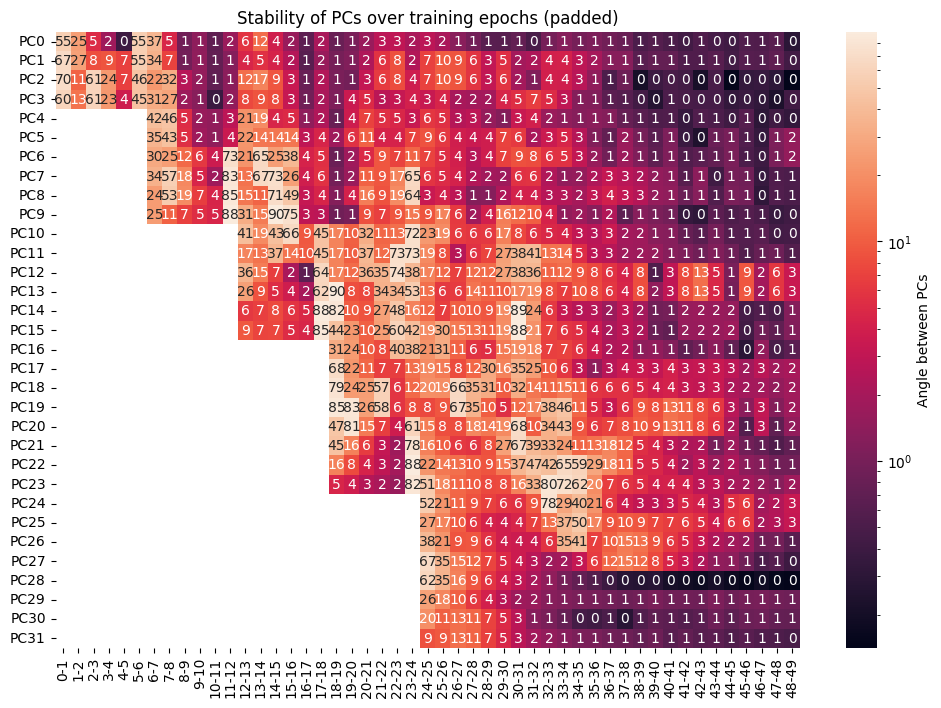

In [17]:
angle_matrix = np.zeros((len(padded_angle_dict), len(all_epoch_pairs)))

# Fill matrix with angle data
for pc, epoch_data in padded_angle_dict.items():
    i = 0
    for epoch_pair in all_epoch_pairs:
        angle_matrix[pc, i] = epoch_data[epoch_pair]
        i += 1

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    angle_matrix, 
    annot=True, 
    fmt=".0f",
    norm=LogNorm(), 
    xticklabels=[f"{e1}-{e2}" for e1, e2 in all_epoch_pairs], 
    yticklabels=[f"PC{pc}" for pc in padded_angle_dict.keys()],
    cbar_kws={"label": "Angle between PCs"})
ax.set_title("Stability of PCs over training epochs (padded)")
plt.show()

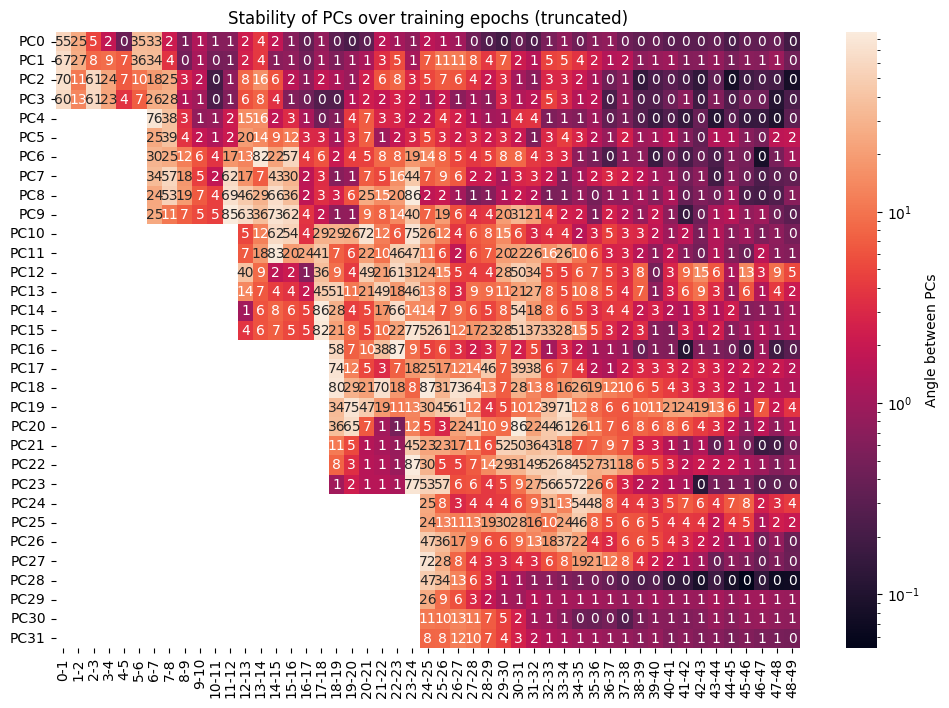

In [18]:

angle_matrix = np.zeros((len(truncated_angle_dict), len(all_epoch_pairs)))

# Fill matrix with angle data
for pc, epoch_data in truncated_angle_dict.items():
    i = 0
    for epoch_pair in all_epoch_pairs:
        angle_matrix[pc, i] = epoch_data[epoch_pair]
        i += 1

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    angle_matrix, 
    annot=True, 
    fmt=".0f",
    norm=LogNorm(), 
    xticklabels=[f"{e1}-{e2}" for e1, e2 in all_epoch_pairs], 
    yticklabels=[f"PC{pc}" for pc in truncated_angle_dict.keys()],
    cbar_kws={"label": "Angle between PCs"})
ax.set_title("Stability of PCs over training epochs (truncated)")
plt.show()